# **Analysis of CTD data from Argo profiling floats deployed by the OCEAN:ICE project** #

For an interactive version of this page please visit the Google Colab:  
[<img src="https://colab.research.google.com/img/colab_favicon_256px.png" height="35px" align=CENTER> Open in Google Colab ](https://colab.research.google.com/drive/1ETwvp7v3mxXVVtrID2YTQ8CwIKIiqIE2)<br>
<sub>(To open link in new tab press Ctrl + click)</sub>

Alternatively this notebook can be opened with Binder by following the link:
[Analysis of CTD data from Argo profiling floats deployed by the OCEAN:ICE project](https://mybinder.org/v2/gh/s4oceanice/literacy.s4oceanice/main?urlpath=%2Fdoc%2Ftree%2Fnotebooks_binder%2Foceanice_argo_floats.ipynb)

OCEAN:ICE employs a cross-disciplinary, combined observational and modelling approach to achieve its scientific objectives. It melds new in situ measurements, targeted at existing spatial and knowledge gaps, with remote sensed EOs together with a hierarchy of modelling approaches. An ambitious set of quasi-simultaneous circumpolar observations is planned to observe the pathways, properties and high-resolution variability of water masses associated with Antarctic ice-ocean interaction over periods of various years. Several arrays of Argo profiling floats are been deployed as part of this strategy.  

The tool uses the following product:

- OCEAN:ICE's ERDDAP (https://er1.s4oceanice.eu/erddap/tabledap/ARGO_FLOATS_OCEANICE.html)

In [1]:
%%capture
# install and import libraries
!pip install netCDF4 cartopy seawater ipympl

%matplotlib ipympl
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.cm as cm
import seawater as sw
import cartopy.crs as ccrs
import cartopy
import pandas as pd
import ipywidgets as widgets
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from matplotlib.backend_bases import PickEvent
from IPython.display import HTML, display
import warnings

warnings.filterwarnings('ignore')

## Mapping OCEAN:ICE deployed Argo Floats

In the next code cell, a map of the Antarctic region will be generated using the Esri Antarctic Basemap projection. The map will display ARGO platforms' sampling locations within the specified time range, marked with unique colors to distinguish each platform. By zooming on the map it is possible to see the trajectory for each Argo platform. The data is fetched from the ERDDAP server, and each platform's sampling points are represented by circle markers. A dropdown menu allows you to select different platforms, updating the current platform value accordingly. Additionally, a legend is displayed to indicate the color associated with each platform.

In [2]:
# Creating a map with antarctic projection
from ipyleaflet import Map, CircleMarker, basemaps, WMSLayer, projections, MarkerCluster
from ipywidgets import VBox, HBox

m3 = Map(basemap=basemaps.Esri.AntarcticBasemap, crs=projections.EPSG3031.ESRIBasemap, center=(-90, 0), zoom=2)

# Define EPSG:3031 projection
EP = dict(
    name='EPSG:3031',
    custom=True,
    proj4def="""+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1
        +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs""",
    bounds=[[-3174450,-2816050],[2867175,2406325]]
)

# Define the URL for ERDDAP data
erddap_url = 'https://er1.s4oceanice.eu/erddap'
dataset_id = 'ARGO_FLOATS_OCEANICE'
data_format = 'csv'
dataset_type = 'tabledap'

# Get minimum and maximum time
csv_info = f'https://er1.s4oceanice.eu/erddap/info/ARGO_FLOATS_OCEANICE/index.csv'
info_df = pd.read_csv(csv_info)
start_time = info_df.loc[info_df['Attribute Name'] == 'time_coverage_start', 'Value'].values[0]
end_time = info_df.loc[info_df['Attribute Name'] == 'time_coverage_end', 'Value'].values[0]


# Construct the full URL for the platforms query
csv_list_of_P = f'{erddap_url}/{dataset_type}/{dataset_id}.{data_format}?PLATFORMCODE&time%3E={start_time}&time%3C={end_time}&distinct()'
plist = pd.read_csv(csv_list_of_P, skiprows=[1])
plist_cleaned = plist.dropna()

# Generate distinct colors using the tab20 colormap
cmap = plt.get_cmap('tab20')
num_colors = len(plist_cleaned)
colors = [mcolors.rgb2hex(cmap(i / num_colors)) for i in range(num_colors)]

# Set initial default value for platform
platform = plist_cleaned.iloc[0]['PLATFORMCODE']

# Add ARGO platforms to the map with unique colors
for plat in range(len(plist_cleaned)):
    platform = plist_cleaned.iloc[plat]['PLATFORMCODE']
    csv_url = f'{erddap_url}/{dataset_type}/{dataset_id}.{data_format}?PLATFORMCODE%2Ctime%2Clatitude%2Clongitude&PLATFORMCODE=%22{platform}%22&time%3E={start_time}&time%3C={end_time}'

    data = pd.read_csv(csv_url, skiprows=[1])
    data_cleaned = data.dropna()
    sampling_points = data_cleaned.drop_duplicates(subset=['latitude', 'longitude'])

    for x in sampling_points.index:
        lat = sampling_points.loc[x, 'latitude']
        lon = sampling_points.loc[x, 'longitude']

        circle_marker = CircleMarker()
        circle_marker.location = (lat, lon)
        circle_marker.radius = 2
        circle_marker.color = colors[plat]
        circle_marker.fill_color = colors[plat]

        m3.add_layer(circle_marker)

# Create HTML legend
legend_html = '<div style="padding: 10px; background: white; border: 1px solid black; font-size: 14px;">'
legend_html += '<strong>Platform ID Legend</strong><br>'
for plat, color in zip(plist_cleaned['PLATFORMCODE'], colors):
    legend_html += f'<span style="color: {color};">&#9679;</span> {plat}<br>'
legend_html += '</div>'

# Display map and legend
display(m3)
display(HTML(legend_html))

platform_list = plist_cleaned['PLATFORMCODE'].astype(str).tolist()

platform = platform_list[0]

# Define the dropdown widget
dropdown = widgets.Dropdown(
    options=platform_list,
    value=platform_list[0],
    description='Platform ID:',
    style={'description_width': 'initial'}
)

# Update the platform variable when the dropdown value changes
def on_platform_change(change):
    global platform
    platform = change.new

dropdown.observe(on_platform_change, names='value')

# display(dropdown)

Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

Dropdown(description='Platform:', options=('1902687', '3902582', '4903780', '4903786', '5907087', '5907093', '…

## Analyze the data for the selected Argo Float

In the next code cell, data related to the selected ARGO platform will be fetched from the ERDDAP server. The data includes parameters such as platform code, cycle number, time, latitude, longitude, pressure, temperature, and salinity, along with their respective quality control (QC) flags, which will be filtered to take into account only values with matching QC value of 1. The data is filtered based on the selected time range. After retrieving the data, it is cleaned by removing any missing values and then converted into an xarray dataset for easy manipulation and visualization. The resulting dataset is displayed, showing its contents and structure.

In [11]:
# Retrieve the data of the selected ARGO FLOAT
file=f"{erddap_url}/{dataset_type}/{dataset_id}.{data_format}?PLATFORMCODE%2Ccycle_number%2Ctime%2Clatitude%2Clongitude%2CPRESS%2CTEMP%2CTEMP_QC%2CPSAL%2CPSAL_QC&PLATFORMCODE=%22{platform}%22&time%3E={start_time}&time%3C={end_time}"
df = pd.read_csv (file, skiprows=[1])

# Filter selecting only rows with PSAL_QC=1 and TEMP_QC=1
df = df[(df['TEMP_QC'] == 1) & (df['PSAL_QC'] == 1)]

df_cleaned = df.dropna()
prof = xr.Dataset.from_dataframe(df)
# Show the content of the file as an xarray
prof

<xarray.Dataset> Size: 80kB
Dimensions:       (index: 904)
Coordinates:
  * index         (index) int64 7kB 0 1 2 3 4 5 6 ... 898 899 900 901 902 903
Data variables:
    PLATFORMCODE  (index) int64 7kB 5907087 5907087 5907087 ... 5907087 5907087
    cycle_number  (index) int64 7kB 2 2 2 2 2 2 2 2 ... 10 10 10 10 10 10 10 10
    time          (index) object 7kB '2024-01-10T05:39:20Z' ... '2024-03-07T1...
    latitude      (index) float64 7kB -68.61 -68.61 -68.61 ... -68.12 -68.12
    longitude     (index) float64 7kB 73.09 73.09 73.09 ... 71.95 71.95 71.95
    PRESS         (index) float64 7kB 8.0 9.0 9.9 15.5 ... 570.9 574.2 575.6
    TEMP          (index) float64 7kB 1.717 1.816 1.727 ... -1.939 -1.938 -1.939
    TEMP_QC       (index) int64 7kB 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PSAL          (index) float64 7kB 33.73 33.91 33.94 ... 34.52 34.52 34.52
    PSAL_QC       (index) int64 7kB 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1

In the next code cell, a scatter plot of sea water temperature versus pressure will be generated for the selected ARGO platform. The x-axis represents the sea water temperature in degrees Celsius (°C), and the y-axis shows the pressure in decibars (dBar). Pressure values are numerically similar (within 2%) to depth in meters below the surface. That is, the pressure at a depth of 1000 meters is about 1000 dbars. The plot allows you to visualize the temperature profile across different depths. The y-axis is inverted to represent deeper depths at the bottom.

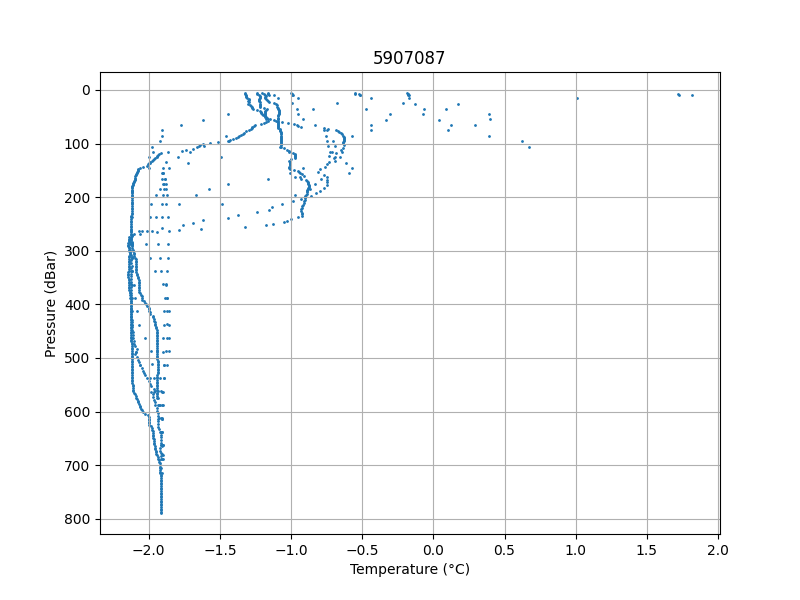

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
scRT = ax.scatter(prof.TEMP, prof.PRESS, s=1, label=f"{platform}")
ax.set_title(f"{platform}")
ax.invert_yaxis()
plt.xlabel('Sea Water Temperature (°C)')
plt.ylabel('Pressure (dBar)')
ax.grid()

In the next code cell, a scatter plot of salinity versus sea water temperature will be generated for the selected ARGO platform. The x-axis represents salinity in practical salinity units (psu), and the y-axis shows the sea water temperature in degrees Celsius (°C). This plot helps visualize the relationship between salinity and temperature in the ocean.

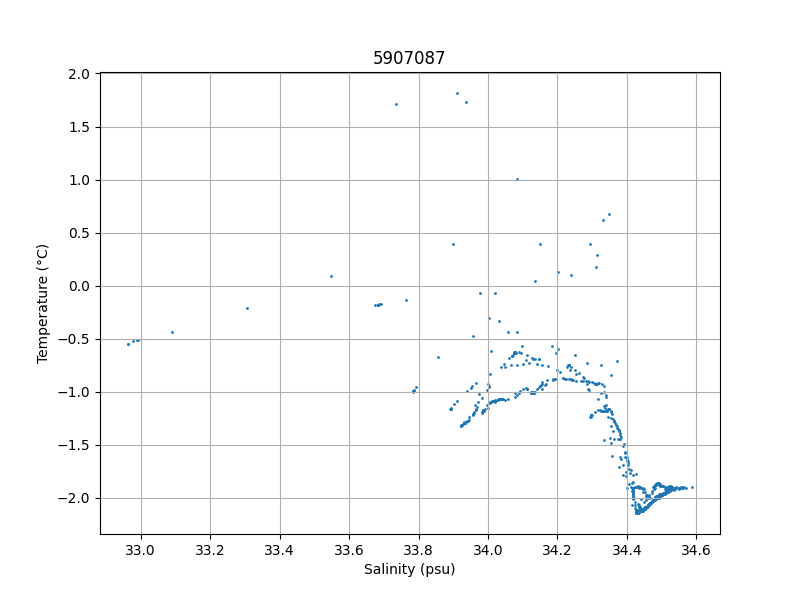

In [13]:
fig, ax = plt.subplots(figsize=(7,5))
scRT = ax.scatter(prof.PSAL, prof.TEMP, s=1)
ax.set_title(f"{platform}")
plt.ylabel('Sea Water Temperature (°C)')
plt.xlabel('Practical Salinity (psu)')
ax.grid()

In the next code cell, a Temperature-Salinity (T-S) diagram is created for the selected ARGO platform. The cell calculates the potential temperature at the sea surface level using salinity, in-situ temperature, and pressure data. Salinity values are then plotted against potential temperature, with colors indicating the density of data points.

The diagram uses a 2D histogram to determine the density of the data points in each temperature-salinity range, highlighting areas with more frequent observations. This visualization helps identify distinct water masses and provides insights into oceanographic conditions around the ARGO float. The color bar shows the density scale.

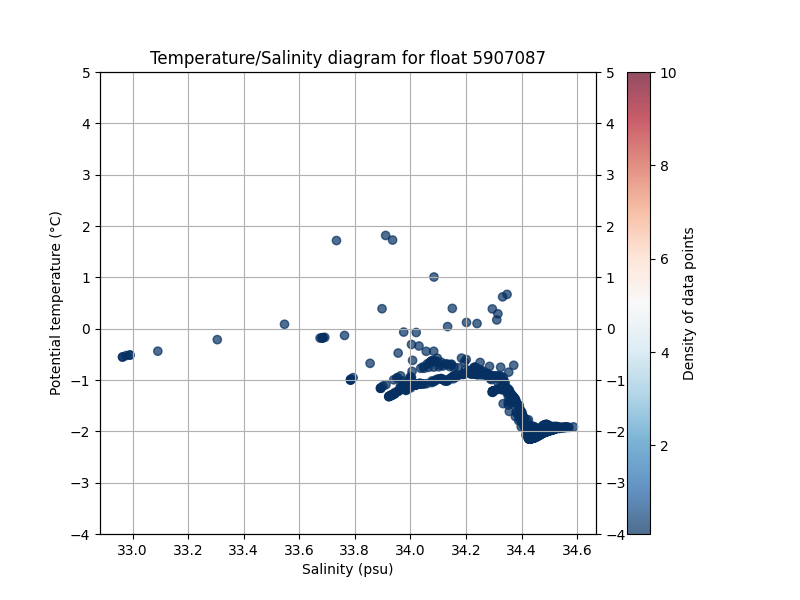

In [24]:
temp = prof.TEMP.values.flatten()
psal = prof.PSAL.values.flatten()
pres = prof.PRESS.values.flatten()

# Compute potential temperature using the seawater package
ptmp = sw.ptmp(psal, temp, pres, pr=0)

# Create bins for the histogram
t_bins = np.linspace(2, 25, 200)
s_bins = np.linspace(35, 37.25, 200)

# Generate a 2D histogram for temperature and salinity
hist, xedges, yedges = np.histogram2d(psal, ptmp, (s_bins, t_bins))
xidx = np.clip(np.digitize(psal, xedges), 0, hist.shape[0] - 1)
yidx = np.clip(np.digitize(ptmp, yedges), 0, hist.shape[1] - 1)
c = hist[xidx, yidx]

# Create the plot
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(
    psal, ptmp,
    c=c, alpha=0.7,
    cmap='RdBu_r',
    vmin=0.1,
    vmax=10
)
ax.set_title(f"Temperature/Salinity diagram for float {platform}")
ax.set_ylabel("Potential Temperature (°C)")
ax.set_xlabel("Practical Salinity (psu)")
ax.set_ylim(-4, 5)
ax.grid()

# Create a secondary y-axis for potential temperature
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())

# Add a single color bar with a label
cbar = fig.colorbar(sc, ax=ax, label='Density of data points')

# Display the plot
plt.show()

In the next code cell, a vertical salinity section plot is generated for the selected ARGO platform. This scatter plot visualizes the relationship between salinity and temperature, with colors representing the negative pressure values (depth).

The plot helps illustrate how salinity and temperature vary with depth, revealing the water column's stratification and structure. The color gradient indicates how different salinity and temperature combinations are distributed across various depths, providing insights into the oceanographic conditions surrounding the ARGO float. The color bar indicates the depth scale, and grid lines aid in reading the plot.

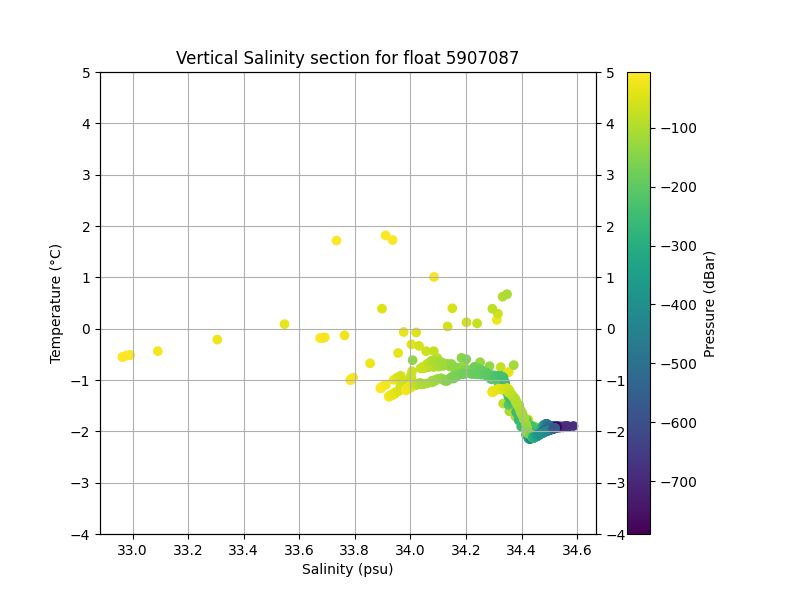

In [22]:
fig, ax = plt.subplots(figsize=(7, 5))

# Scatter plot with pressure color-coded
sc = ax.scatter(prof.PSAL, prof.TEMP, c=-prof.PRESS)
ax.set_title(f"Vertical Salinity section for float {platform}")
ax.set_xlabel("Practical Salinity (psu)")
ax.set_ylabel("Sea Water Temperature (°C)")
ax.set_ylim(-4, 5)
ax.grid()

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())

cbar = fig.colorbar(sc, ax=ax, label='Pressure (dBar)')

plt.show()

In the next code cell, a trajectory plot of the selected Argo float data will be displayed.

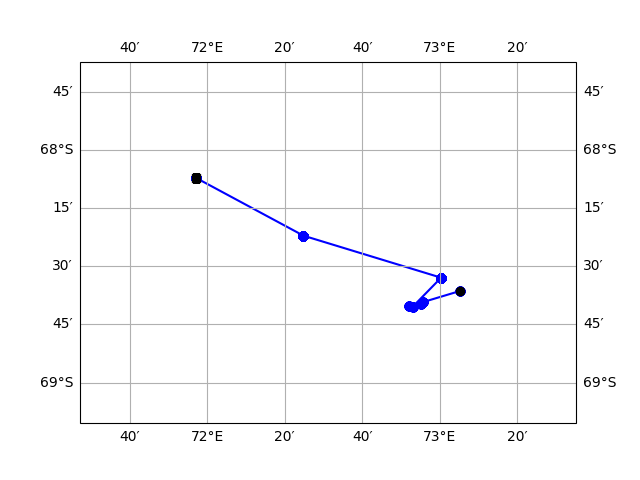

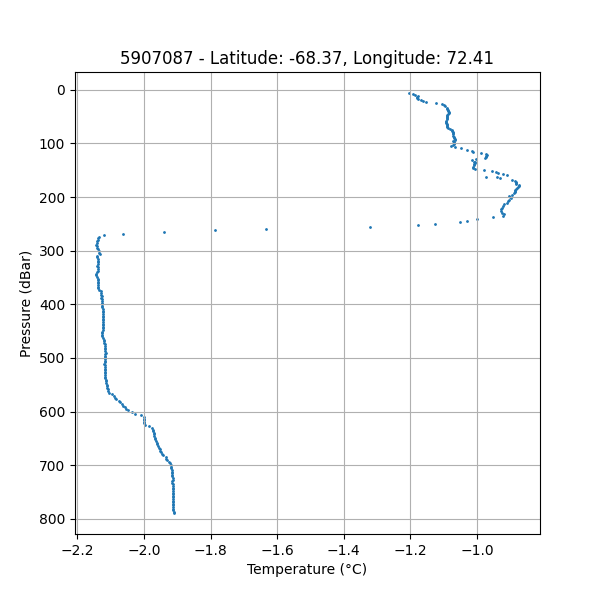

In [16]:
vp_fig = None
vp_ax = None

# Function to create the vertical profile plot, to be called on click
def vertical_profile(lat, lon):
    global vp_fig, vp_ax

    if vp_fig is None or vp_ax is None:
        vp_fig, vp_ax = plt.subplots(figsize=(6, 6))
        vp_ax.set_xlabel('Sea Water Temperature (°C)')
        vp_ax.set_ylabel('Pressure (dBar)')
        vp_ax.invert_yaxis()
        vp_ax.grid()

    vp_ax.clear()

    distances = (prof.latitude - lat) ** 2 + (prof.longitude - lon) ** 2
    matching_points = distances <= 1e-4

    if matching_points.sum() > 0:
        temperature = prof.TEMP.values[matching_points]
        pressure = prof.PRESS.values[matching_points]

        # Plot the vertical profile
        vp_ax.scatter(temperature, pressure, s=1, label=f"{platform}")
        vp_ax.set_title(f"{platform} - Latitude: {lat:.2f}, Longitude: {lon:.2f}")
        vp_ax.set_xlabel('Sea Water Temperature (°C)')
        vp_ax.set_ylabel('Pressure (dBar)')
        vp_ax.invert_yaxis()
        vp_ax.grid()
        vp_fig.canvas.draw()
    else:
        print(f"No matching data found for Latitude: {lat}, Longitude: {lon}")

def on_point_click(event):
    if isinstance(event, PickEvent):
        xdata, ydata = event.artist.get_data()
        xclick, yclick = event.mouseevent.xdata, event.mouseevent.ydata

        longitude = xclick
        latitude = yclick

        distances = (xdata - xclick) ** 2 + (ydata - yclick) ** 2
        index = np.argmin(distances)
        longitude = prof.longitude.values[index]
        latitude = prof.latitude.values[index]
        vertical_profile(latitude, longitude)

# Create and display the trajectory plot
fig_1, ax_1 = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

def set_map_extent(ax, lon_min, lon_max, lat_min, lat_max):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

def get_map_extent(prof):
    lon_min = prof.longitude.min().values
    lon_max = prof.longitude.max().values
    lat_min = prof.latitude.min().values
    lat_max = prof.latitude.max().values
    return lon_min, lon_max, lat_min, lat_max

# Set the map extent based on the data
lon_min, lon_max, lat_min, lat_max = get_map_extent(prof)
set_map_extent(ax_1, lon_min-0.5, lon_max+0.5, lat_min-0.5, lat_max+0.5)

# Plot your data points
scatter = ax_1.plot(prof.longitude, prof.latitude, 'ob', picker=True)
ax_1.plot(prof.longitude, prof.latitude, '-b')
ax_1.plot(prof.longitude[0], prof.latitude[0], 'ok')
ax_1.plot(prof.longitude[-1], prof.latitude[-1], 'sk')

# Add map features
ax_1.add_feature(cfeature.LAND)
ax_1.add_feature(cfeature.COASTLINE, edgecolor='white')
ax_1.set_title(f"Trajectory of {platform}", y=-1)
ax_1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Connect the click event to the figure canvas
fig_1.canvas.mpl_connect('pick_event', on_point_click)

# Display the plot
plt.show()

## Data visualization for all the platforms

In the next code cell, a vertical temperature profile plot is created for multiple ARGO platforms. Each ARGO float's temperature versus pressure data is plotted as a scatter plot, with different colors representing different platforms.

The plot shows how the temperature varies with depth (pressure) for each platform, allowing for comparisons across multiple floats. Each platform's data points are color-coded according to a pre-defined color scheme, and a legend is provided to distinguish between the platforms. The y-axis is inverted to correctly represent increasing depth downward.

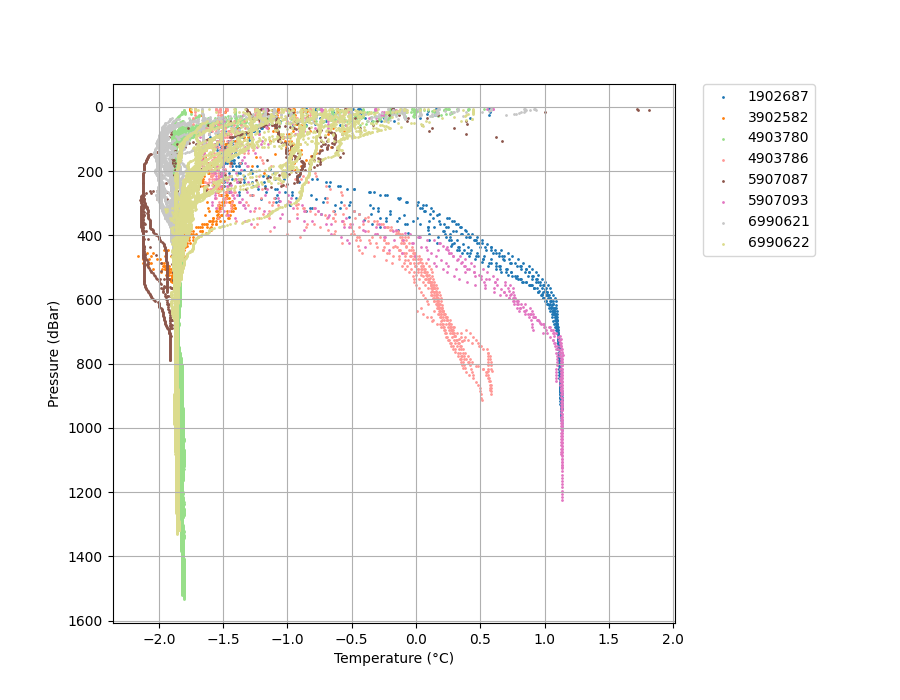

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

for plat in range(len(plist_cleaned)):
  plat_code = plist_cleaned.loc[plat, 'PLATFORMCODE']

  file=f"{erddap_url}/{dataset_type}/{dataset_id}.{data_format}?PLATFORMCODE%2Ccycle_number%2Ctime%2Clatitude%2Clongitude%2CPRESS%2CTEMP%2CTEMP_QC%2CPSAL%2CPSAL_QC&PLATFORMCODE=%22{plat_code}%22&time%3E={start_time}&time%3C={end_time}"
  df = pd.read_csv (file, skiprows=[1])
  df_cleaned = df.dropna()
  pro = xr.Dataset.from_dataframe(df)
  cols = str(colors[plat])

  verticalT = ax.scatter(pro.TEMP, pro.PRESS, s=1, color = cols, label=f"{plat_code}")

ax.invert_yaxis()
plt.xlabel('Sea Water Temperature (°C)')
plt.ylabel('Pressure (dBar)')
ax.grid()

plt.subplots_adjust(right=0.75)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In the next code cell, a scatter plot is generated to visualize the relationship between salinity and potential temperature across multiple ARGO platforms. Each platform's data is plotted with distinct colors to represent different floats.

The plot shows salinity on the x-axis and potential temperature on the y-axis. The salinity and temperature data points are color-coded according to a pre-defined color scheme, which corresponds to different ARGO platforms. The x-axis is limited to a range of 33 to 37 psu, and the y-axis is constrained between -4 and 5 °C to focus on the relevant data ranges.

This visualization helps to compare the salinity and potential temperature characteristics of different ARGO platforms within the specified dataset.

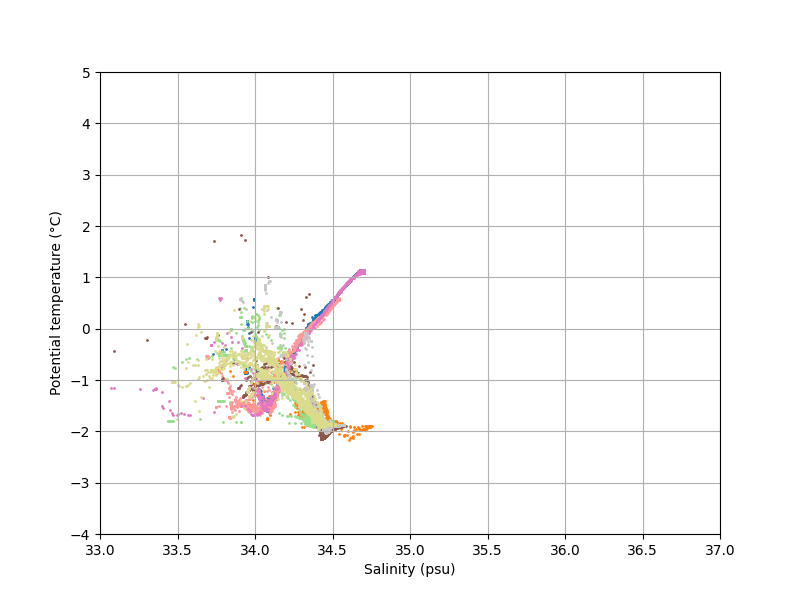

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

for plat in range(len(plist_cleaned)):
  plat_code = plist_cleaned.loc[plat, 'PLATFORMCODE']

  file=f"{erddap_url}/{dataset_type}/{dataset_id}.{data_format}?PLATFORMCODE%2Ccycle_number%2Ctime%2Clatitude%2Clongitude%2CPRESS%2CTEMP%2CTEMP_QC%2CPSAL%2CPSAL_QC&PLATFORMCODE=%22{plat_code}%22&time%3E={start_time}&time%3C={end_time}"
  df = pd.read_csv (file, skiprows=[1])
  df_cleaned = df.dropna()
  pro = xr.Dataset.from_dataframe(df)
  cols = str(colors[plat])

  verticalT = ax.scatter(pro.PSAL, pro.TEMP, s=1, color = cols, label=f"{plat_code}")

plt.xlabel('Practical Salinity (psu)')
plt.ylabel('Potential Temperature (°C)')
ax.set_ylim (-4, 5)
ax.set_xlim (33, 37)

ax.grid()
plt.subplots_adjust(right=0.75)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

### **Additional resources**

The Python libraries that have been used in this notebook are:
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/)
- [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/)
- [requests](https://requests.readthedocs.io/en/latest/)
- [seawater](https://pypi.org/project/seawater/)
- [numpy](https://numpy.org/)
- [pandas](https://pandas.pydata.org/)
- [traitlets](https://traitlets.readthedocs.io/en/stable/)
- [matplotlib](https://matplotlib.org/)
- [IPython](https://ipython.org/)